In [121]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [122]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [123]:
# Load txt file
with open('data/hello-algo-python.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [124]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 172150
The maximum value in the tokenized text is: 100207


In [125]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [126]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [127]:
# Illustrate batches
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15
0  99771  13821    234  13828    110  91739    223   9174  30624  29129    220     21  57064     19  47850    222
1   9554  20675  17620  52927  89874   3922  44388  98184  40474  13828    113   9554  20834  47551    162  25451
2  48864  18476    863  78640  48982  20675   1811  49691    229  30624  98739  13821    234   4916    249  41073
3  70924   1811  19000  16175    122  11589    240  14608    240  91272  33208    198  34547   3922  70141  17297


In [128]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100208, 64)


In [129]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [130]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


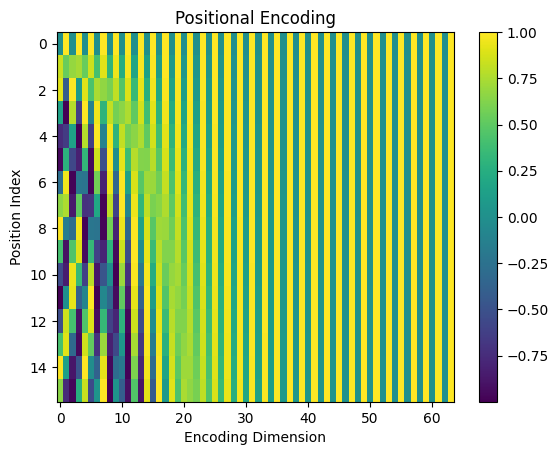

In [131]:
# Illustrate position encoding lookup table
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [132]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.103055,1.752677,-1.116129,2.153939,0.015708,1.187534,-0.380603,1.832536,1.018685,0.547363,...,-0.530165,1.813268,0.460151,0.587700,-0.328056,1.845757,-1.158454,1.154678,0.151858,0.348593
1,-1.139982,-0.456457,0.750826,-1.367986,1.737360,1.497206,0.539171,0.606694,1.482351,-0.263479,...,0.559744,1.773637,-0.610662,-0.296844,-1.478100,-0.539012,-1.794086,0.321865,0.551958,0.761638
2,0.866404,-0.513048,1.231818,0.346209,2.036019,-1.372262,-0.176886,1.238892,-0.196484,0.185768,...,0.763183,0.762612,-0.940464,0.126786,-0.631069,1.446220,-0.732343,0.578193,-0.936161,1.093850
3,1.041123,0.214417,0.862819,1.100914,0.567515,-2.517436,1.293149,0.603707,0.988282,2.205420,...,-0.220795,1.011344,-0.253781,-0.741833,-0.469843,0.139721,2.221972,0.464144,0.054312,1.136760
4,-0.284803,-0.932270,2.361385,-0.427828,1.255690,-2.073403,0.358659,0.412936,0.250396,-1.256658,...,0.664094,2.613986,-0.120177,-0.289203,1.503965,0.421694,0.300814,0.493272,1.635301,0.413783
5,0.149017,-0.447633,0.371668,-0.773190,-0.109700,0.667377,0.015691,-1.921121,2.159904,0.710462,...,-0.405181,2.533143,0.069416,1.376409,0.336063,2.522855,-0.211277,1.414180,1.332296,0.489129
6,-0.239091,0.666541,0.191545,1.299443,-1.553835,1.153617,1.271333,-1.513390,-0.222280,-1.143061,...,0.420687,0.122515,-0.029862,1.002193,1.024453,0.313056,0.808945,-0.385917,-0.517968,0.519273
7,0.642201,0.684806,-0.612390,1.254920,-1.493599,-1.578576,-0.756594,-1.572139,1.333886,-0.339924,...,0.695044,1.325427,2.295247,1.966663,-0.493551,0.504541,-1.402807,1.001814,1.351590,2.233287
8,1.663524,1.123023,-1.341431,0.434914,-0.370084,-0.052951,1.514358,-0.405404,0.250180,0.429695,...,-0.030014,1.734653,-0.780451,1.042467,-0.118684,0.962091,0.362321,0.062387,-1.063701,0.331704
9,0.040665,-1.244766,1.000301,1.468966,-4.397838,-0.615368,-1.259794,0.182219,-1.823159,0.094367,...,-1.849054,2.552276,2.629730,1.198762,-1.081669,0.718736,0.813315,0.368543,0.105640,1.734406


In [133]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [134]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.040011  0.253023 -0.226968 -0.126807  0.923302  0.207020  0.859829 -0.689606  0.448020  0.946492  0.241136  0.800777 -0.642658  0.119746 -0.011825  0.939792
1  0.988000  0.316761 -0.419790 -0.192152 -0.142750 -0.148212  0.270297  0.633704  0.519085  0.515384 -0.613958  0.684775  0.622539  0.678671 -0.125564  0.147000
2  0.675490 -0.960671  0.089421  0.010924 -0.401003 -0.068997  0.073294  0.334392  1.095434 -0.816870 -0.201882 -0.243253  0.154032 -0.229535  0.228030 -0.529241
3  1.065624 -0.325761 -0.285846 -1.066758  0.985736 -0.661524  0.010813 -0.333088  0.535886 -0.526896  0.393367  0.352528 -0.740570  0.230162  0.532906 -0.563555
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -1.052427 -0.076296  0.930

In [135]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.647717,0.988722,0.767607,-0.689946,-0.111673,0.153788,-0.318857,-0.568241,0.259560,-0.001827,-0.586575,-0.242127,-0.434807,0.060160,0.127136,0.106291
1,-0.323929,0.137289,0.293024,-0.078047,0.732081,-0.202519,-0.563156,0.161328,-0.013779,0.027026,-0.024039,0.164647,0.147073,0.063658,0.964820,1.042083
2,-0.396113,0.334639,0.471107,-0.362118,0.773809,-0.260941,-0.493644,-0.049768,-0.197393,0.113349,-0.317723,-0.383771,-0.096871,-0.502251,0.572487,0.496314
3,-0.042746,0.006072,-0.003204,0.054347,0.579304,-0.080381,-0.214965,1.084789,0.128385,0.547776,0.308713,0.167294,-0.043059,-0.167329,0.181257,1.036993
4,-0.399443,0.062226,-0.068853,0.071899,0.463563,-0.470619,-0.101542,0.399906,0.188514,0.255635,0.195382,-0.244485,-0.094247,-0.362060,0.642567,0.665666
5,-0.336365,0.828199,0.447506,-0.565487,-0.641899,-0.475676,-0.391656,-0.405547,-0.145224,0.500576,-0.749710,-0.020507,-0.218132,-0.147920,-0.472476,0.210130
6,-0.485695,0.771179,1.096750,-0.115932,-0.173749,0.020279,-0.683888,0.387776,-0.072838,0.278670,-0.637771,-0.280842,-0.430709,0.226363,0.048926,0.660607
7,-0.228435,0.211419,0.405200,-0.257391,0.005525,-0.164589,-0.472046,0.422245,0.106691,0.647336,-0.009227,0.059909,0.602641,-0.214115,0.428936,0.137749
8,-0.328454,0.261279,-0.227596,-0.217649,-0.341406,-0.241322,-0.151085,-0.179153,-0.091159,-0.038103,-0.125628,-0.309548,-0.791609,-0.408026,0.421309,0.491370
9,-0.226662,0.317411,0.501668,-0.066252,-0.259358,-0.204813,-0.195224,0.249019,0.898087,0.303961,-0.162506,-0.215155,-0.027638,0.808947,0.364520,0.521118


/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24076 (\N{CJK UNIFIED IDEOGRAPH-5E0C}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20914 (\N{CJK UNIFIED IDEOGRAPH-51B2}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31361 (\N{CJK UNIFIED IDEOGRAPH-7A81}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 229

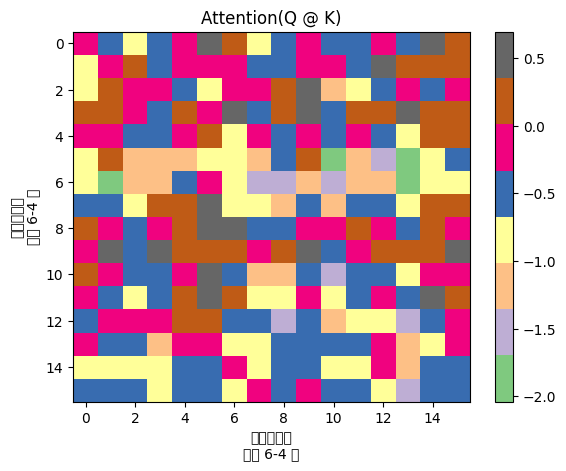

In [136]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.647717,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.323929,0.137289,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.396113,0.334639,0.471107,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.042746,0.006072,-0.003204,0.054347,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,-0.399443,0.062226,-0.068853,0.071899,0.463563,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.336365,0.828199,0.447506,-0.565487,-0.641899,-0.475676,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.485695,0.771179,1.096750,-0.115932,-0.173749,0.020279,-0.683888,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-0.228435,0.211419,0.405200,-0.257391,0.005525,-0.164589,-0.472046,0.422245,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.328454,0.261279,-0.227596,-0.217649,-0.341406,-0.241322,-0.151085,-0.179153,-0.091159,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.226662,0.317411,0.501668,-0.066252,-0.259358,-0.204813,-0.195224,0.249019,0.898087,0.303961,-inf,-inf,-inf,-inf,-inf,-inf


/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24076 (\N{CJK UNIFIED IDEOGRAPH-5E0C}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20914 (\N{CJK UNIFIED IDEOGRAPH-51B2}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31361 (\N{CJK UNIFIED IDEOGRAPH-7A81}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 229

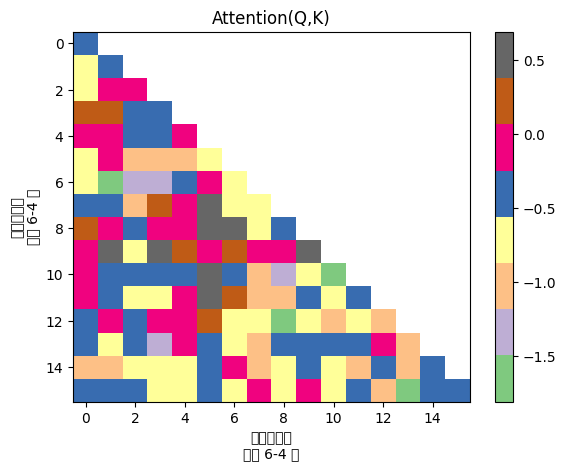

In [137]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [138]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.386697,0.613303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.183253,0.380552,0.436195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.238531,0.250465,0.248152,0.262852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.125771,0.199564,0.175047,0.201504,0.298113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.113683,0.364301,0.248958,0.090404,0.083754,0.098900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.068150,0.239507,0.331675,0.098640,0.093098,0.113033,0.055897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.095799,0.148726,0.180528,0.093065,0.121051,0.102115,0.075086,0.183631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.093215,0.168114,0.103107,0.104138,0.092015,0.101701,0.111305,0.108225,0.118179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.065024,0.112036,0.134704,0.076337,0.062932,0.066460,0.067100,0.104630,0.200237,0.110540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [140]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [141]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.250906,-0.184396,-0.719563,0.068629,0.202457,-0.175869,0.106626,0.203072,-0.174533,-0.447432,...,-0.542102,0.287022,0.380923,0.585475,-0.100306,0.146799,0.662911,0.435711,0.189189,0.108676
1,0.142854,-0.032620,-0.178331,-0.139089,0.012339,-0.187257,-0.330909,0.244411,-0.079063,-0.487997,...,-0.221994,-0.245422,0.003328,0.441227,-0.080002,-0.080636,0.143124,0.486972,0.012640,0.096315
2,0.065659,0.018227,-0.136044,-0.118312,-0.221088,-0.242335,-0.124634,0.532767,-0.309684,-0.528333,...,-0.187961,-0.199681,-0.156235,0.367162,-0.145707,-0.153109,0.223462,0.721389,-0.143201,0.109204
3,0.214980,0.034792,-0.280948,-0.201474,-0.016472,-0.164546,0.069156,0.698424,-0.259701,-0.464453,...,-0.325035,-0.023018,0.008431,0.414124,-0.054627,-0.191505,0.333112,0.825742,-0.303688,0.185734
4,0.099741,-0.019124,-0.205826,-0.173630,-0.193571,-0.120914,-0.055840,0.675335,-0.156172,-0.377917,...,-0.150592,-0.205541,-0.023497,0.507120,-0.159767,-0.147725,0.329553,0.588972,-0.242461,0.035730
5,0.035822,-0.004739,-0.197917,-0.145669,-0.073209,-0.149752,-0.148145,0.645216,0.029654,-0.401240,...,-0.210622,-0.191617,0.042177,0.398622,-0.081731,-0.180113,0.106543,0.623117,-0.034174,0.007017
6,-0.003882,0.045567,-0.278241,-0.175789,-0.071252,-0.131024,-0.071990,0.629146,-0.101024,-0.417250,...,-0.179367,-0.110502,0.029234,0.399584,-0.087246,-0.087375,0.281954,0.510030,-0.187069,0.149406
7,0.007483,-0.074956,-0.352592,-0.101255,0.018388,-0.184832,0.063968,0.533939,-0.040994,-0.470542,...,-0.213156,-0.123403,0.067463,0.309257,0.003391,-0.046048,0.289351,0.551693,-0.112676,0.061200
8,0.051030,0.005913,-0.344901,-0.147300,0.065165,-0.139972,0.024317,0.465174,-0.040937,-0.494219,...,-0.150826,-0.088021,0.061408,0.349037,0.077739,-0.053318,0.240766,0.499431,-0.143395,0.173429
9,0.111632,0.092403,-0.386155,-0.036555,0.053143,-0.113643,-0.066001,0.433837,0.034677,-0.400999,...,-0.156096,-0.095372,-0.008542,0.360423,-0.005131,-0.094968,0.055028,0.641830,-0.143542,0.156221


In [142]:
# Add residual connection
output = output + X

In [143]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [144]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [145]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [146]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [147]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100198,100199,100200,100201,100202,100203,100204,100205,100206,100207
0,0.530809,-0.009325,-0.938465,-0.546178,0.027011,0.001724,0.172910,0.297292,0.011546,0.486874,...,-0.119963,0.998181,0.344579,-0.479219,-0.269343,-0.391563,-0.190548,-0.265716,-0.111743,0.082119
1,0.243809,0.467102,-0.437254,-0.782944,-0.496731,0.386016,0.360197,0.563898,-0.724166,-0.190912,...,-0.086269,-0.839326,0.503753,0.902110,0.271889,0.470354,0.102493,0.110153,-0.460464,-0.371350
2,0.250196,0.225018,-1.054623,-0.504533,-1.340962,-0.086143,0.752280,1.221599,0.113906,0.462351,...,0.520621,0.371672,0.440410,0.756054,0.369071,-0.131770,0.223821,-0.640807,-0.214175,0.559817
3,0.405358,0.107929,0.567712,-0.716976,0.314516,-0.040718,0.811490,-0.228481,-0.527264,-0.639160,...,0.277397,-0.484876,0.931608,0.045222,-0.375193,0.259235,0.150322,0.266017,-0.922242,0.457803
4,-0.558567,0.535391,-0.089571,-0.620725,0.484562,0.367694,0.283445,0.398525,0.754977,-0.017797,...,0.525556,0.472608,0.784621,1.496186,0.846585,0.645396,0.499534,-0.276873,-0.089261,0.170685
5,0.528042,0.224035,0.235740,-1.022676,0.818297,0.817269,-0.005438,0.633009,0.190353,0.948452,...,0.294408,0.102276,0.233605,-0.265805,-0.376154,-1.270669,0.008371,0.285442,0.257610,0.580468
6,0.469424,1.025849,-0.719448,-0.855157,1.259442,-0.080892,-0.572022,0.551872,-0.129462,-0.125356,...,-0.287810,0.619506,0.875880,-0.041877,-0.710149,-0.028296,-0.856772,-0.139500,-0.649882,0.137925
7,0.096673,0.555276,-0.467611,-0.318385,-0.009819,-0.269073,1.023406,0.304021,-0.205800,0.082159,...,1.116926,0.496952,-0.445981,0.367588,0.416608,-0.108572,-0.108819,-0.516370,-1.315278,-0.092938
8,0.815549,0.843631,-0.056836,-1.199130,0.057082,0.043096,0.804178,1.206687,0.306990,0.083345,...,-0.246598,-0.169291,0.323899,-0.091875,0.038485,-0.522673,-0.081026,-0.053265,-0.368111,0.596637
9,-0.438126,0.027149,0.436807,-0.446818,-0.173003,-0.135740,-0.528243,1.141455,0.466929,-0.232679,...,0.908117,0.305980,0.092575,0.721367,-0.003428,-0.841425,0.175997,0.824714,-1.116969,0.148127


In [148]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100198,100199,100200,100201,100202,100203,100204,100205,100206,100207
0,0.000014,0.000008,0.000003,0.000005,0.000009,0.000008,0.000010,0.000011,0.000009,0.000014,...,0.000007,0.000023,0.000012,0.000005,0.000006,0.000006,0.000007,0.000006,0.000008,0.000009
1,0.000011,0.000013,0.000005,0.000004,0.000005,0.000012,0.000012,0.000015,0.000004,0.000007,...,0.000008,0.000004,0.000014,0.000021,0.000011,0.000013,0.000009,0.000009,0.000005,0.000006
2,0.000011,0.000011,0.000003,0.000005,0.000002,0.000008,0.000018,0.000029,0.000009,0.000013,...,0.000014,0.000012,0.000013,0.000018,0.000012,0.000007,0.000011,0.000004,0.000007,0.000015
3,0.000013,0.000009,0.000015,0.000004,0.000012,0.000008,0.000019,0.000007,0.000005,0.000004,...,0.000011,0.000005,0.000021,0.000009,0.000006,0.000011,0.000010,0.000011,0.000003,0.000013
4,0.000005,0.000014,0.000008,0.000005,0.000014,0.000012,0.000011,0.000013,0.000018,0.000008,...,0.000014,0.000013,0.000018,0.000038,0.000020,0.000016,0.000014,0.000006,0.000008,0.000010
5,0.000014,0.000011,0.000011,0.000003,0.000019,0.000019,0.000008,0.000016,0.000010,0.000022,...,0.000011,0.000009,0.000011,0.000006,0.000006,0.000002,0.000008,0.000011,0.000011,0.000015
6,0.000014,0.000024,0.000004,0.000004,0.000030,0.000008,0.000005,0.000015,0.000007,0.000007,...,0.000006,0.000016,0.000020,0.000008,0.000004,0.000008,0.000004,0.000007,0.000004,0.000010
7,0.000009,0.000015,0.000005,0.000006,0.000008,0.000006,0.000023,0.000011,0.000007,0.000009,...,0.000026,0.000014,0.000005,0.000012,0.000013,0.000008,0.000008,0.000005,0.000002,0.000008
8,0.000019,0.000020,0.000008,0.000003,0.000009,0.000009,0.000019,0.000028,0.000011,0.000009,...,0.000007,0.000007,0.000012,0.000008,0.000009,0.000005,0.000008,0.000008,0.000006,0.000015
9,0.000005,0.000009,0.000013,0.000005,0.000007,0.000007,0.000005,0.000026,0.000013,0.000007,...,0.000021,0.000011,0.000009,0.000017,0.000008,0.000004,0.000010,0.000019,0.000003,0.000010


In [149]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' Xiao'

In [150]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

'哈希冲突。\n如图 6‑4 所'